我们将建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，你有两个考试的申请人的分数和录取决定。为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率。

In [153]:
from jupyterthemes import jtplot
jtplot.style(theme = 'oceans16', grid = True, figsize = (12,8))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
pdData = pd.read_csv('C:/Users/shi.yx.sz/Desktop/LogiReg_data.txt', 
                     header=None, 
                     names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [155]:
pdData.shape

(100, 3)

Text(0,0.5,'Exam 2 Score')

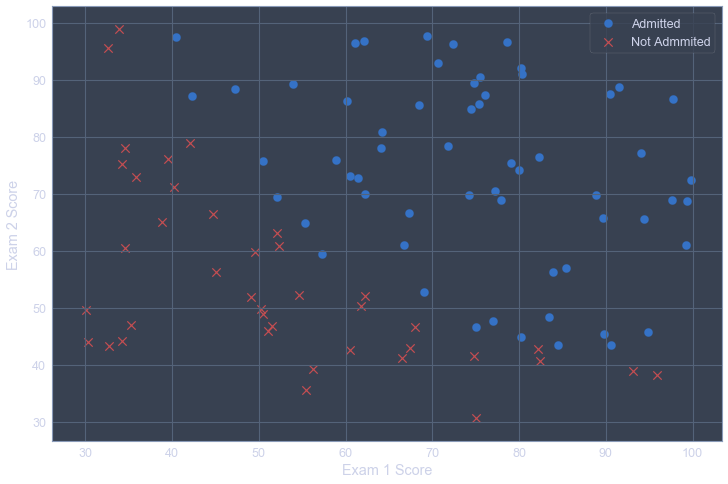

In [156]:
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]
plt.figure(figsize = (12, 8))
plt.scatter(positive['Exam 1'], positive['Exam 2'], s = 70, label = 'Admitted')
plt.scatter(negative['Exam 1'], negative['Exam 2'], s = 70, c = 'r', marker = 'x',label = 'Not Admmited')
plt.legend(loc = 'best')
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')

## 逻辑回归
目标：建立分类器（求解出三个参数 $\theta_0         \theta_1         \theta_2 $）


设定阈值，根据阈值判断录取结果

### 要完成的模块
-  `sigmoid` : 映射到概率的函数

-  `model` : 返回预测结果值

-  `cost` : 根据参数计算损失

-  `gradient` : 计算每个参数的梯度方向

-  `descent` : 进行参数更新

-  `accuracy`: 计算精度

###  `sigmoid` 函数

$$
g(z) = \frac{1}{1+e^{-z}}   
$$

In [157]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Text(0.5,1,'Sigmoid')

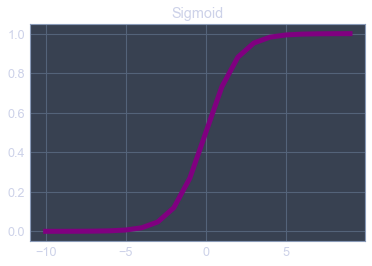

In [158]:
nums = np.arange(-10, 10)
plt.plot(nums, sigmoid(nums), 'purple', linewidth = 5)
plt.title('Sigmoid')

`model`

$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [159]:
def model(X, theta):
    return sigmoid(np.dot(X,theta.T))

In [160]:
pdData.insert(0, 'Ones', 1)
orig_data = pdData.values
orig_data
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]
theta = np.zeros([1, 3])

In [161]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

### `cost`
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [162]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [163]:
cost(X, y, theta)

0.6931471805599453

### `gradient`


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$


In [164]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta) - y).ravel()
    for j in range(len(theta.ravel())):
        term = np.multiply(error, X[:, j])
        grad[0, j] = np.sum(term) / len(X)
        
    return grad

### Gradient descent
比较3种不同的梯度下降方法

In [165]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    #设定3种不同的停止策略
    if type == STOP_ITER:      return value > threshold
    elif type == STOP_COST:    return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:    return np.linalg.norm(value) < threshold   

In [166]:
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:,cols-1:]
    return X, y

`descent`

In [167]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
        
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [168]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

### 不同的停止策略

#### 设定迭代次数

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.45s


array([[-0.00027127,  0.00705232,  0.00376711]])

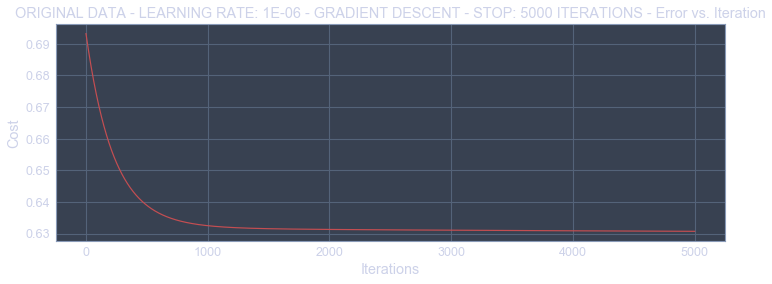

In [169]:
#选择的梯度下降方法是基于所有样本的
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### 根据损失值停止

设定阈值 1E-6, 差不多需要110 000次迭代 

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 31.91s


array([[-5.13364014,  0.04771429,  0.04072397]])

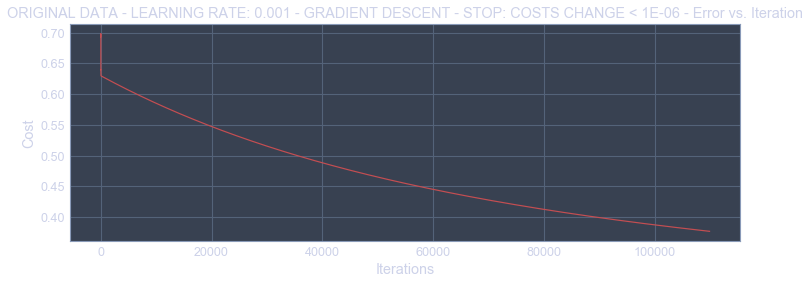

In [171]:
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

#### 根据梯度变化停止

设定阈值 0.05,差不多需要40 000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 12.31s


array([[-2.37033409,  0.02721692,  0.01899456]])

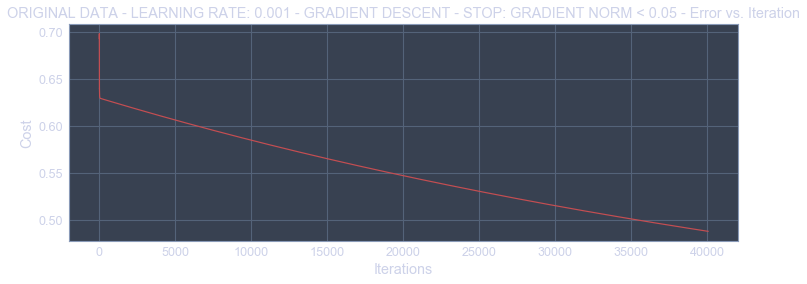

In [172]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

### 对比不同的梯度下降方法

随机梯度下降

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.38199827  0.06599685  0.05771363]] - Iter: 5000 - Last cost: 2.48 - Duration: 0.58s


array([[-0.38199827,  0.06599685,  0.05771363]])

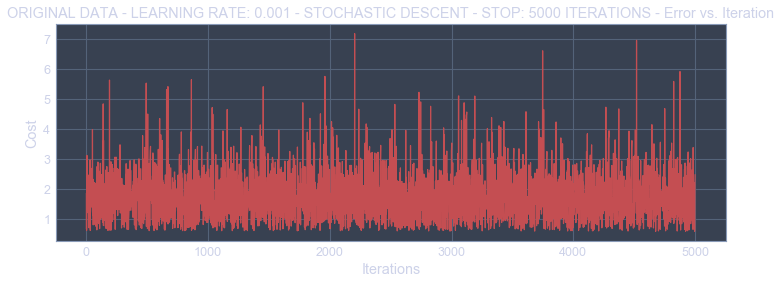

In [173]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00202038  0.01008899  0.00099922]] - Iter: 15000 - Last cost: 0.63 - Duration: 1.71s


array([[-0.00202038,  0.01008899,  0.00099922]])

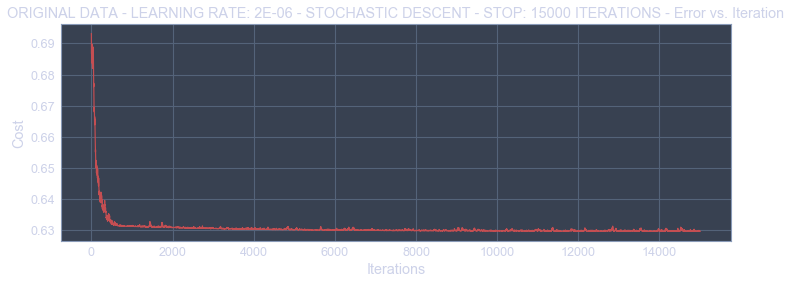

In [174]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

速度快，但稳定性差，需要很小的学习率

#### Mini-batch descent

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.03468264  0.02405957  0.01298871]] - Iter: 15000 - Last cost: 0.61 - Duration: 2.12s


array([[-1.03468264,  0.02405957,  0.01298871]])

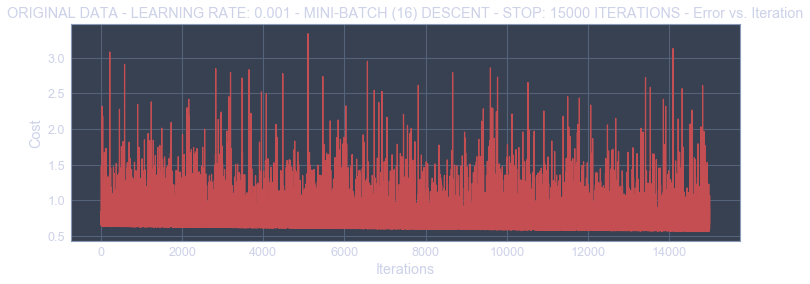

In [175]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动仍然比较大，我们来尝试下对数据进行标准化
将数据按其属性(按列进行)减去其均值，然后除以其方差。最后得到的结果是，对每个属性/每列来说所有数据都聚集在0附近，方差值为1

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[0.3080807  0.86494967 0.77367651]] - Iter: 5000 - Last cost: 0.38 - Duration: 1.53s


array([[0.3080807 , 0.86494967, 0.77367651]])

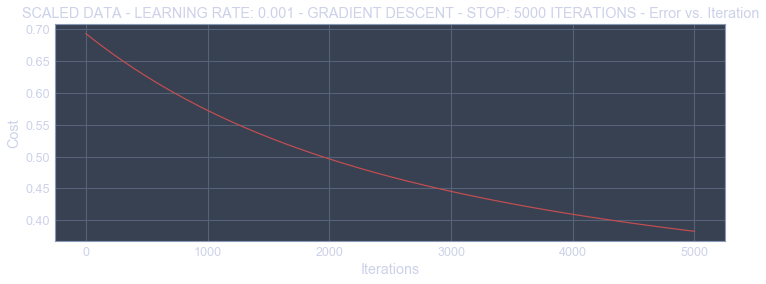

In [176]:
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)

它好多了！原始数据，只能达到达到0.61，而我们得到了0.38个在这里！
所以对数据做预处理是非常重要的

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.02
Theta: [[1.0707921  2.63030842 2.41079787]] - Iter: 59422 - Last cost: 0.22 - Duration: 18.87s


array([[1.0707921 , 2.63030842, 2.41079787]])

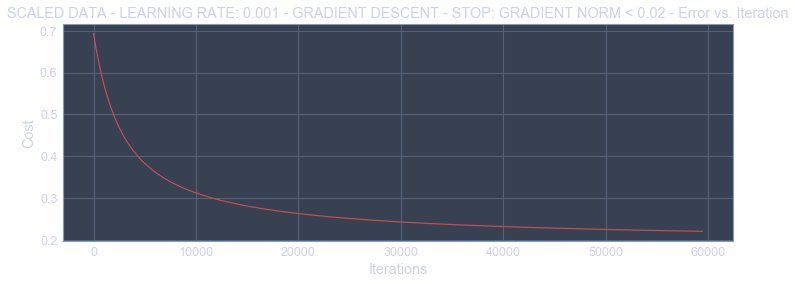

In [177]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

更多的迭代次数会使得损失下降的更多！

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[1.1501718  2.79392913 2.56377073]] - Iter: 72574 - Last cost: 0.22 - Duration: 10.10s


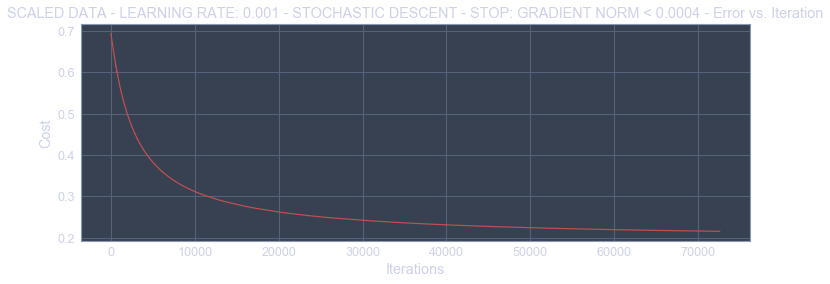

In [178]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

随机梯度下降更快，但是我们需要迭代的次数也需要更多，所以还是用batch的比较合适！！！

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.004
Theta: [[1.15178404 2.79815291 2.5673018 ]] - Iter: 356 - Last cost: 0.22 - Duration: 0.08s


array([[1.15178404, 2.79815291, 2.5673018 ]])

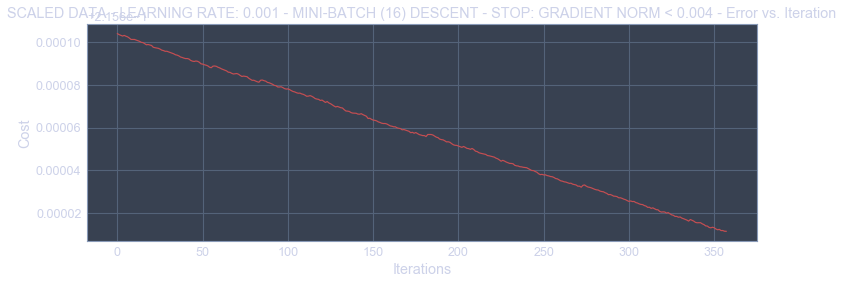

In [179]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)